# Data Preparation Notebook

In this notebook, our aim is to preprocess our dataset and prepare it for the demand prediction. This process involves cleaning the data, filling missing values, handling outliers, and other essential steps.

## Preprocessing

Due to the original taxi trips dataset's large size (>10 GB), we utilize the data preprocessing tool [csvkit](https://csvkit.readthedocs.io/en/latest/) to remove unwanted rows from the dataset. We used commands that significantly reduced the dataset's size without deleting rows necessary for our tasks.

All rows that included the following arguments were dropped from the dataset:

- "Trip Seconds" and "Trip Miles" = 0
- "Pickup Centroid Latitude" = Null
- "Dropoff Centroid Latitude" = Null
- "Pickup Census Tract" = Null
- "Trip Seconds" = Null

We selected these arguments because we could not utilize the affected rows in the subsequent exercises due to them containing missing or unusable data. These initial preprocessing steps enabled us to reduce the dataset size from 10 GB to 6 GB, facilitating its loading into a Jupyter notebook.

## Importing Necessary Libraries

We start by importing the necessary libraries, each serving a specific purpose in our data preparation process:

- `numpy` and `pandas`: Essential libraries for data handling and manipulation.
- `datetime`: Module for manipulating dates and times.
- `geopandas`: A tool to handle geographic data.
- `seaborn` and `matplotlib.pyplot`: Libraries for data visualization.
- `gc`: Python's garbage collector, useful for managing memory.
- `pickle`: A module for serializing and deserializing Python objects, facilitating data saving and loading.
- `google.colab`: A module enabling interaction with Google Colab, including reading data from Google Drive and adjusting the dataframe display.



In [ ]:
import numpy as np
import pandas as pd
import datetime
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

import gc
import pickle

from google.colab import drive
from google.colab import data_table
data_table.enable_dataframe_formatter()

from IPython.display import display, clear_output
import time

import warnings
warnings.filterwarnings('ignore')

## Data Acquisition and Initial Data Exploration
### Loading and Cleaning Data in Chunks

Our dataset, containing taxi trip records for 2013, resides in a CSV file on Google Drive. Given the limitations of RAM, we will load and process the data in chunks, allowing us to handle large datasets efficiently without overburdening memory resources.

The steps involved in our data loading process include:

1. **Mounting the Google Drive**: This gives us access to the files stored in the Google Drive.

2. **Chunk Loading**: We load the CSV file in manageable chunks using the `pandas.read_csv()` function.

3. **Initial Data Cleaning within Chunks**: For each chunk, we perform essential data cleaning tasks, including removing invalid entries (trips with 0 seconds or miles), dropping unneeded columns ('Pickup Community Area' and 'Dropoff Community Area'), and removing duplicate entries.

4. **Concatenating Chunks**: Finally, we concatenate the cleaned chunks into a single DataFrame, which is ready for subsequent preprocessing tasks.


In [ ]:
# Mount the Google Drive to access the data file
drive.mount('/content/drive')
csv_file_path = '/content/drive/MyDrive/TME/Data/taxi_trips_2013.csv'

# Define the chunk size for data loading
chunk_size = 1000000

# Define a function to perform data cleaning tasks within each chunk
def process_chunk(chunk):
    # Discard trips with 0 'Trip Seconds' or 'Trip Miles'
    chunk = chunk[(chunk[['Trip Seconds', 'Trip Miles']] > 0).all(axis=1)]

    # Discard unneeded columns
    chunk = chunk.drop(['Pickup Community Area', 'Dropoff Community Area'], axis=1)

    # Remove duplicate entries
    chunk = chunk.drop_duplicates(keep='first')

    return chunk

# Initialize an empty list to hold processed chunks
processed_chunks = []

# Load and process the data in chunks
chunks = pd.read_csv(csv_file_path, chunksize=chunk_size)
for chunk in chunks:
    processed_chunk = process_chunk(chunk)
    processed_chunks.append(processed_chunk)

# Concatenate all processed chunks into a single DataFrame
df_trips = pd.concat(processed_chunks, ignore_index=True)

# Clear up some memory
del processed_chunks, chunks
gc.collect()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


0

## Inspecting the DataFrame Structure

Understanding the structure and format of our data is a critical first step in any data analysis or preprocessing pipeline. By checking the size, non-null count, and data type of each column in our DataFrame, we can identify potential issues such as missing values or inappropriate data types. These insights inform our strategy for subsequent data cleaning and transformation operations.



In [ ]:
# Get an overview of the DataFrame
df_trips.info()

# Display the first few rows of the DataFrame to visually inspect the data
df_trips.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9001450 entries, 0 to 9001449
Data columns (total 21 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   Trip ID                     object 
 1   Taxi ID                     object 
 2   Trip Start Timestamp        object 
 3   Trip End Timestamp          object 
 4   Trip Seconds                float64
 5   Trip Miles                  float64
 6   Pickup Census Tract         int64  
 7   Dropoff Census Tract        int64  
 8   Fare                        float64
 9   Tips                        float64
 10  Tolls                       float64
 11  Extras                      float64
 12  Trip Total                  float64
 13  Payment Type                object 
 14  Company                     object 
 15  Pickup Centroid Latitude    float64
 16  Pickup Centroid Longitude   float64
 17  Pickup Centroid Location    object 
 18  Dropoff Centroid Latitude   float64
 19  Dropoff Centroid Long

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Fare,Tips,...,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,d9c9335742e48cb845bbc05089145cf9b8b0c3cc,ff27b6ba27a8301516d11c41574b1c1dcb529bf9d4e5a2...,12/11/2013 12:00:00 AM,12/11/2013 12:30:00 AM,1380.0,18.6,17031980000,17031320600,37.05,0.0,...,2.0,39.05,Cash,Dispatch Taxi Affiliation,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),41.870607,-87.622173,POINT (-87.6221729369 41.8706073724)
1,e3477767844072c9c81948ce097ef5f85662c926,18f4d1898ead14ae8bc4828a02ead3e6c6294429ebf347...,09/23/2013 04:45:00 AM,09/23/2013 05:15:00 AM,2460.0,17.9,17031320100,17031980000,38.05,5.0,...,2.0,45.05,Credit Card,Taxi Affiliation Services,41.884987,-87.620993,POINT (-87.6209929134 41.8849871918),41.979071,-87.903040,POINT (-87.9030396611 41.9790708201)
2,2d950cf31e72b549541b77b27776c4c2869d7cbb,ff27b6ba27a8301516d11c41574b1c1dcb529bf9d4e5a2...,12/11/2013 12:00:00 AM,12/11/2013 12:00:00 AM,240.0,0.7,17031081500,17031320100,5.05,0.0,...,0.0,5.05,Cash,Dispatch Taxi Affiliation,41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),41.884987,-87.620993,POINT (-87.6209929134 41.8849871918)
3,de85b0693d7e87ef291a4c68f95cbf0901629ada,ff27b6ba27a8301516d11c41574b1c1dcb529bf9d4e5a2...,12/11/2013 12:00:00 AM,12/11/2013 12:15:00 AM,300.0,0.8,17031320100,17031081800,5.45,0.0,...,0.0,5.45,Cash,Dispatch Taxi Affiliation,41.884987,-87.620993,POINT (-87.6209929134 41.8849871918),41.893216,-87.637844,POINT (-87.6378442095 41.8932163595)
4,51f77286392b6881de3ebe65c1befbe4ae9da4ea,ff27b6ba27a8301516d11c41574b1c1dcb529bf9d4e5a2...,12/10/2013 11:45:00 PM,12/11/2013 12:00:00 AM,420.0,1.3,17031081500,17031320400,6.45,0.0,...,0.0,6.45,Cash,Dispatch Taxi Affiliation,41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),41.877406,-87.621972,POINT (-87.6219716519 41.8774061234)


## Data Cleaning
### Identifying Missing Values

Missing values, represented as NaNs in our DataFrame, can pose a significant challenge in data analysis. They can lead to inaccurate results and biased analysis if not handled properly. Therefore, our next step is to inspect our DataFrame for these missing values. By identifying the columns and rows containing these NaNs, we can develop a strategy to handle them, whether by imputation, deletion, or other methods.


In [ ]:
# Get the rows where at least one cell has a missing value
rows_with_nan = df_trips[df_trips.isna().any(axis=1)]
print(f"There are {len(rows_with_nan)} rows with at least one missing value.")

# Get the list of columns with missing values
columns_with_nan = df_trips.columns[df_trips.isna().any()].tolist()
print(f"Columns with missing values: {columns_with_nan}")

# Get the count of missing values in each of these columns
missing_values_count = df_trips[columns_with_nan].isna().sum()
print(f"\nCount of missing values in each column:\n{missing_values_count}")


There are 5413501 rows with at least one missing value.
Columns with missing values: ['Taxi ID', 'Fare', 'Tips', 'Tolls', 'Extras', 'Trip Total', 'Company']

Count of missing values in each column:
Taxi ID           196
Fare              140
Tips              140
Tolls          219112
Extras            140
Trip Total        140
Company       5194392
dtype: int64


### Managing Missing Values

Handling missing values is a crucial step to ensure the robustness and accuracy of our data analyses.

In our dataset, the 'Company' column has missing values which we cannot reasonably infer, hence we will replace them with 'Unknown'.

For the 'Fare' column, we calculate the average cost per kilometer for instances with valid fare and distance values. We then use this average to fill missing values in the 'Fare' column. Note that we convert miles to kilometers to better align with global measurement standards.

Lastly, for the 'Extras', 'Tips', and 'Tolls' columns, we replace the missing values with the mean of the respective columns. This is a common approach to fill in missing values and will work well since the percentage of missing data is low.

After filling in the missing fare components, we recalculate the 'Trip Total' where it is missing, summing the 'Fare', 'Extras', 'Tips', and 'Tolls' columns.


In [ ]:
# Handle missing values in the 'Company' column
df_trips['Company'].fillna('Unknown', inplace=True)

# Convert 'Trip Miles' to kilometers for more universal understanding
df_trips['Trip Miles'] = df_trips['Trip Miles'] * 1.609344
df_trips.rename(columns={"Trip Miles": "Trip Kilometers"}, inplace = True)

# Filter instances with valid fare and distance values
valid_instances = df_trips[['Fare', 'Trip Kilometers']].notna().all(axis=1)

# Compute the average cost per kilometer for valid instances
average_cost_per_km = (df_trips.loc[valid_instances, 'Fare'] / df_trips.loc[valid_instances, 'Trip Kilometers']).mean()

# Clean up memory
del valid_instances
gc.collect()

# Fill 'Fare' missing values using the average cost per kilometer
df_trips['Fare'].fillna(df_trips['Trip Kilometers'] * average_cost_per_km, inplace=True)

# Fill 'Extras', 'Tips', and 'Tolls' missing values with their respective means
for column in ['Extras', 'Tips', 'Tolls']:
    df_trips[column].fillna(df_trips[column].mean(), inplace=True)

# Recalculate 'Trip Total' for instances where it is missing
df_trips.loc[df_trips['Trip Total'].isna(), 'Trip Total'] = df_trips[['Fare', 'Extras', 'Tips', 'Tolls']].sum(axis=1)

# Drop rows where 'Taxi ID' is missing, which is not a problem since this only affects 196 instances
df_trips.dropna(subset=['Taxi ID'], inplace=True)

# Reset the index
df_trips.reset_index(drop=True, inplace=True)

After handling the missing values, we can validate that there are indeed no remaining missing values in our DataFrame to ensure that our data is now ready for further analysis.


In [ ]:
# Get the rows where at least one cell has a missing value
rows_with_nan = df_trips[df_trips.isna().any(axis=1)]
print(f"There are {len(rows_with_nan)} rows with at least one missing value.")

# Get the list of columns with missing values
columns_with_nan = df_trips.columns[df_trips.isna().any()].tolist()
print(f"Columns with missing values: {columns_with_nan}")

# Get the count of missing values in each of these columns
missing_values_count = df_trips[columns_with_nan].isna().sum()
print(f"\nCount of missing values in each column:\n{missing_values_count}")

There are 0 rows with at least one missing value.
Columns with missing values: []

Count of missing values in each column:
Series([], dtype: float64)


### Exploratory Data Analysis: Identifying Outliers
As part of our data exploration process, it is important to identify potential outliers in our dataset. Outliers can significantly skew our data and influence the results of our analysis. We focus on features such as 'Trip Seconds', 'Distance', 'Fare', 'Extras', 'Tips', 'Tolls', and 'Trip Total', which are likely candidates for outliers due to their continuous nature. To better visualize and understand the distribution of these features, we generate box plots, which effectively highlight the outliers.


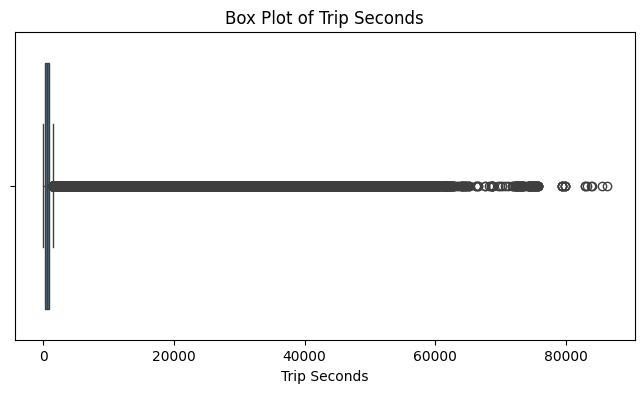

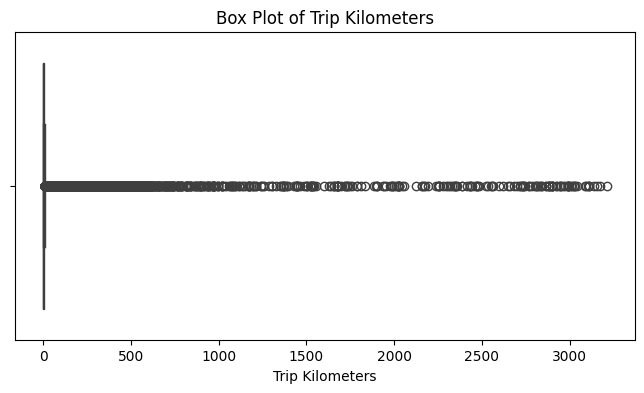

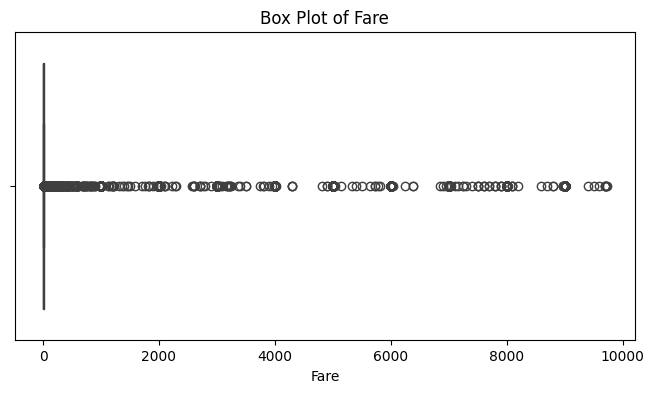

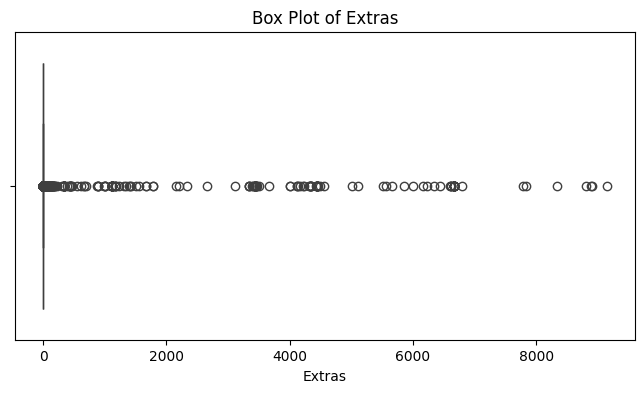

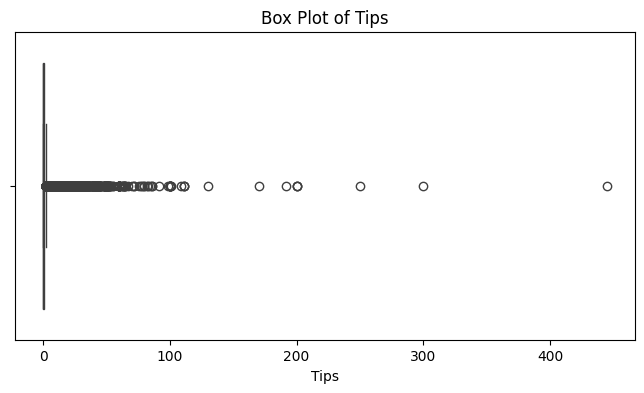

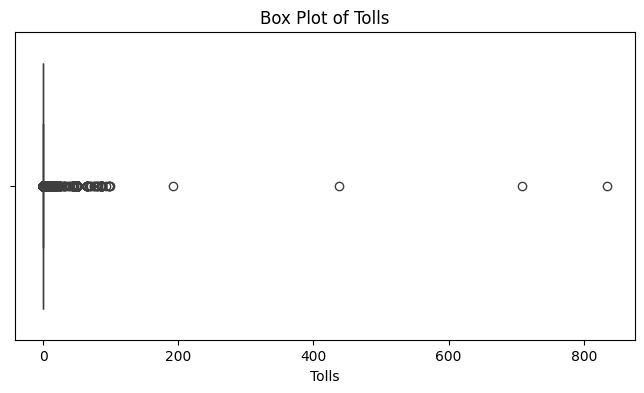

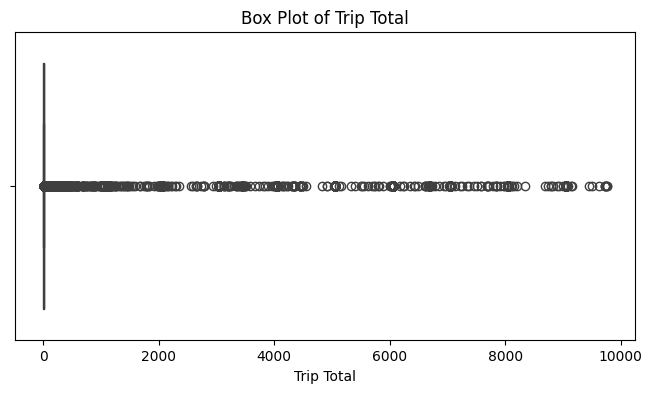

In [ ]:
# Define the list of features that are likely to have outliers
features_with_potential_outliers = ['Trip Seconds', 'Trip Kilometers', 'Fare', 'Extras', 'Tips', 'Tolls', 'Trip Total']

for feature in features_with_potential_outliers:

    # Plot the histogram of the feature
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df_trips[feature])
    plt.title('Box Plot of ' + feature)
    plt.show()


### General Feature Outlier Removal
For most of our features, outliers will be values that are unreasonably high or low compared to the bulk of the data. One effective way to identify these outliers is by examining the data's percentiles. In this step, we will remove data points that fall outside the 1st and 99th percentiles for select features, ensuring they represent a more typical range.



In [ ]:
# Define the list of features where outliers need to be addressed
general_features_with_outliers = ['Fare', 'Extras', 'Tips', 'Tolls', 'Trip Total']

# Initialize a mask with all rows set to True
mask = pd.Series([True]*len(df_trips))

for feature in general_features_with_outliers:
    # Compute the 1st and 99th percentiles for the current feature
    lower_threshold, upper_threshold = df_trips[feature].quantile([0.01, 0.99])

    # Create a feature-specific mask, where True indicates that the feature's value is within the defined thresholds
    feature_mask = (df_trips[feature] >= lower_threshold) & (df_trips[feature] <= upper_threshold)

    # Combine the feature-specific mask with the overall mask, preserving only rows where all features are within the defined thresholds
    mask &= feature_mask

# Apply the mask to the DataFrame to keep only rows without outliers
df_trips = df_trips[mask]
print(f"Number of instances to be removed: {(~mask).sum()}")
del mask
gc.collect()


Number of instances to be removed: 302850


12787

# Domain-Specific Outlier Removal
Considering the nature of taxi trips, it's essential to incorporate domain knowledge into our outlier removal process. We will first filter the data based on reasonable thresholds for trip duration and distance:

- **Duration**: The shortest trips could last around 2 minute, such as when someone changes their mind immediately after getting into the taxi or when the destination is incredibly close. On the longer end, a 1-hour trip is exceptionally lengthy for a city taxi but could account for longer trips like airport rides.
- **Distance**: 0.1 km could be a minimum reasonable distance for recording a taxi trip. In contrast, 50 km could be considered an extended city ride.
  
Subsequently, we will compute the average speed for each trip and filter out records that indicate implausibly slow or fast speeds (for reference: [Chicago taffic report](https://www.tomtom.com/traffic-index/chicago-traffic/)
  
- **Speed**: Considering city traffic and possible idle times, an average speed as low as 5 km/h might be realistic. On the other end, while taxis can go fast on highways or open roads, averaging 80 km/h for an entire trip seems excessive and likely an outlier.

- **Identical Pickup and Dropoff**: Trips where the pickup and dropoff locations are precisely identical are suspicious. Given the precision of GPS coordinates, it's highly unlikely for a taxi trip to start and end at the exact same spot.





In [ ]:
# Define thresholds
min_duration = 120      # 2 minutes in seconds
max_duration = 3600     # 1 hour in seconds
min_distance = 0.1      # km
max_distance = 50       # km
min_speed = 5           # km/h
max_speed = 80          # km/h

# Initialize counter for removed instances
removed_instances = 0

# Set chunk size
chunk_size = 100000
chunks = [x for x in range(0, df_trips.shape[0], chunk_size)]

# Function to process a chunk
def process_chunk(df_chunk):
    # Mask for duration and distance
    mask_duration_distance = (df_chunk['Trip Seconds'].between(min_duration, max_duration)) & \
                             (df_chunk['Trip Kilometers'].between(min_distance, max_distance))

    # Calculate speed in km/h for each trip
    df_chunk['Speed'] = df_chunk['Trip Kilometers'] * 3600 / df_chunk['Trip Seconds']

    # Mask for speed
    mask_speed = df_chunk['Speed'].between(min_speed, max_speed)

    # Function to check if values in a row are identical
    def check_identical(row):
        return row['Pickup Centroid Location'] != row['Dropoff Centroid  Location']

    # Mask for non-identical pickup and dropoff locations
    mask_identical_locations = df_chunk.apply(check_identical, axis=1)

    # Combine all masks
    final_mask = mask_duration_distance & mask_speed & mask_identical_locations

    # Update removed instances counter
    removed = (~final_mask).sum()

    # Filter the dataframe chunk
    return df_chunk[final_mask], removed

cleaned_chunks = []

# Process each chunk except the last one
for i in range(len(chunks) - 1):
    cleaned_df_chunk, removed = process_chunk(df_trips.iloc[chunks[i]:chunks[i+1]])
    cleaned_chunks.append(cleaned_df_chunk)
    removed_instances += removed

# Concatenate the cleaned chunks to get the updated dataframe
df_trips = pd.concat(cleaned_chunks, ignore_index=True)

# Drop the Speed column from the entire DataFrame
df_trips.drop(columns=['Speed'], inplace=True, errors='ignore')

print(f"Number of instances removed: {removed_instances}")

# Clean up
del cleaned_chunks, cleaned_df_chunk, chunks
gc.collect()

Number of instances removed: 2151327


9286

### Post-Outlier Removal: Feature Visualization
Having removed the outliers from our dataset, we can visualize our refined features once again. This helps us to confirm the efficacy of our outlier removal process and provides an improved understanding of our data's distributions. With these clear and outlier-free distributions, we are better prepared for the upcoming tasks.


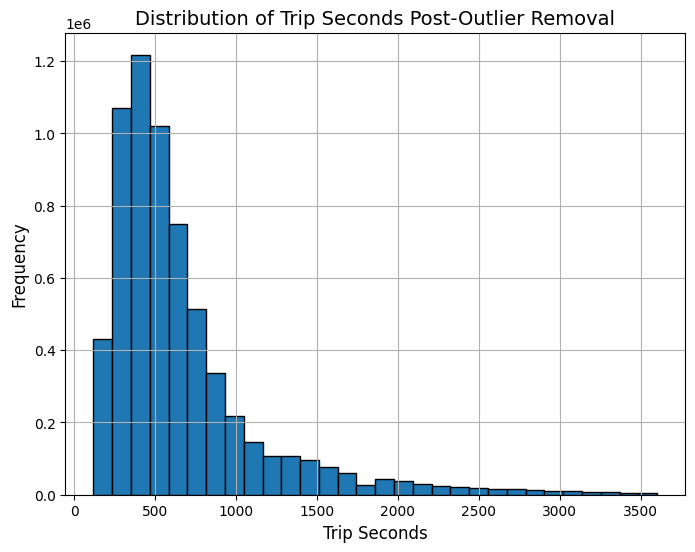

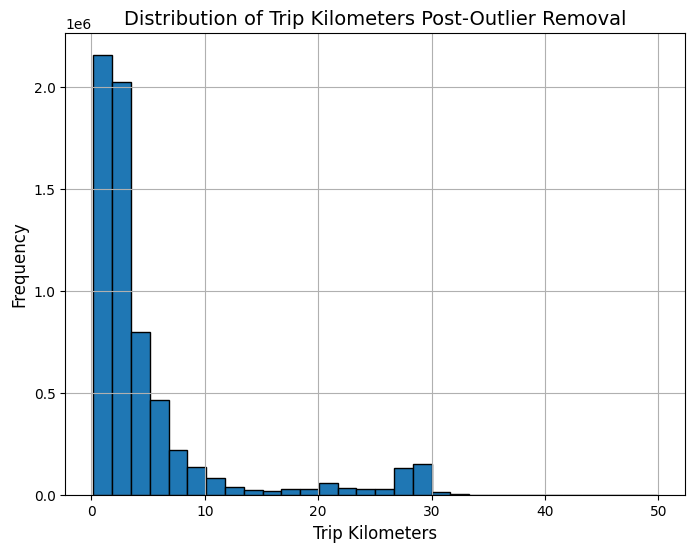

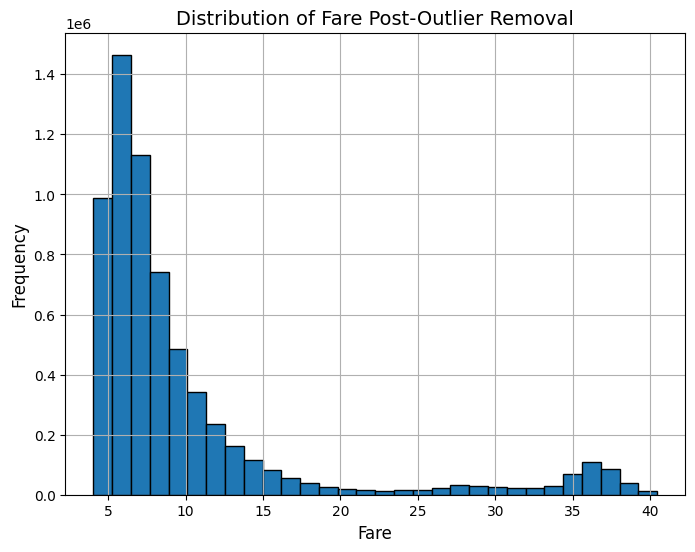

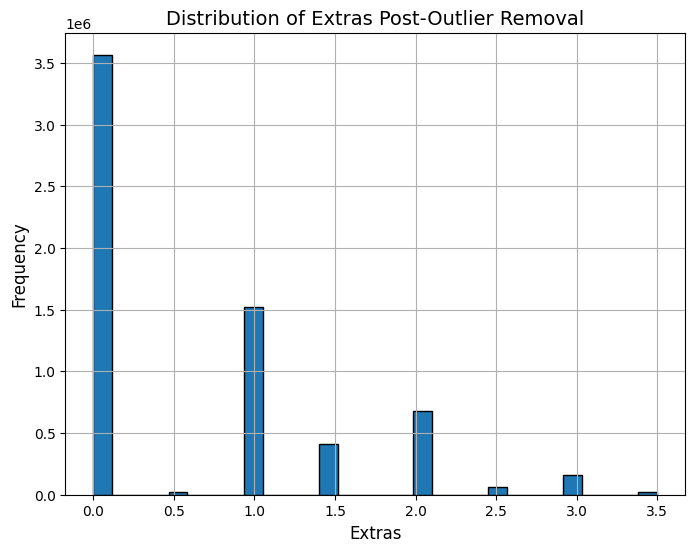

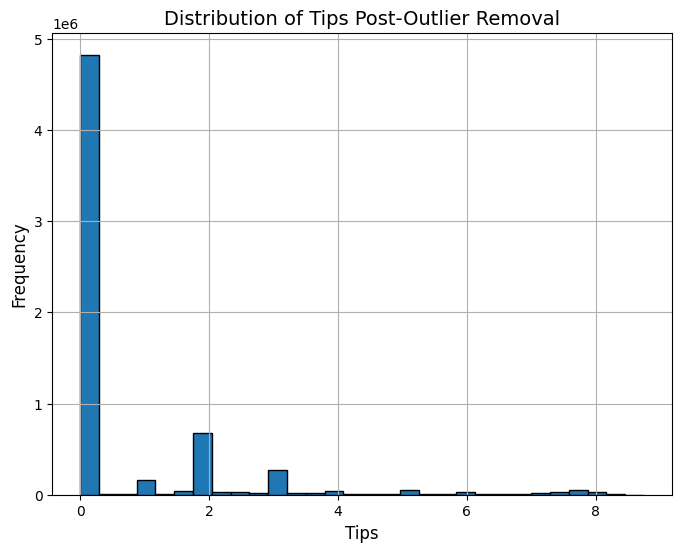

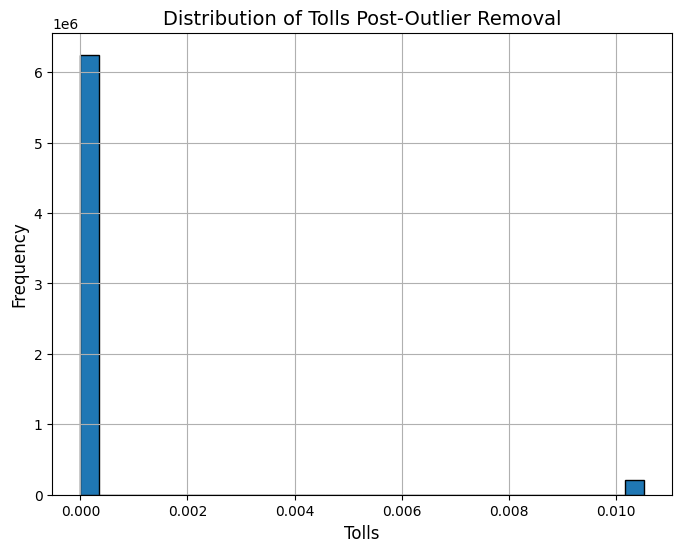

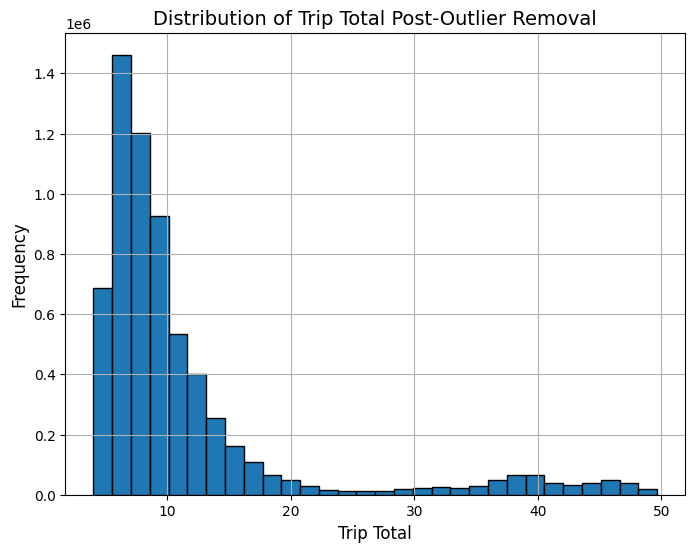

In [ ]:
# List of features where outliers were expected and handled
features_with_outliers = ['Trip Seconds', 'Trip Kilometers', 'Fare', 'Extras', 'Tips', 'Tolls', 'Trip Total']

# Generate histograms for each feature to understand the final distributions
for feature in features_with_outliers:

    # Create a new figure
    plt.figure(figsize=(8,6))

    # Plot the histogram of the feature
    df_trips[feature].hist(bins=30, edgecolor='black')

    # Set the title and labels of the plot
    plt.title(f'Distribution of {feature} Post-Outlier Removal', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)

    # Display the plot
    plt.show()


## Data Formatting and Column Arrangement

Having cleaned our dataset, we'll now focus on improving its usability and readability. Our steps include:

1. **Datetime Conversion**: Ensure that the trip timestamps are in the correct datetime format.
2. **Sorting**: Arrange the data chronologically by the start timestamp of each trip.
3. **Index Resetting**: Reset the dataset's indices for easier data access.
4. **Column Renaming**: Adopt a consistent naming scheme for all columns.
5. **Column Rearrangement**: Order columns logically, ensuring related columns are adjacent.


In [ ]:
# Convert to datetime format
df_trips['Trip Start Timestamp'] = pd.to_datetime(df_trips['Trip Start Timestamp'])
df_trips['Trip End Timestamp'] = pd.to_datetime(df_trips['Trip End Timestamp'])

# Sort values
df_trips = df_trips.sort_values('Trip Start Timestamp', ascending=True)

# Update index
df_trips.reset_index(drop=True, inplace=True)

# Rename columns
# Corrected the typo in "Dropoff Centroid  Location"
df_trips.rename(columns={"Trip ID": "trip_id", "Taxi ID": "taxi_id", "Trip Start Timestamp": "start_time",
                         "Trip End Timestamp": "end_time", "Trip Seconds": "duration", "Trip Kilometers": "distance",
                         "Pickup Census Tract": "start_census_tract", "Dropoff Census Tract": "end_census_tract",
                         "Fare": "fare", "Extras": "extras", "Tips": "tips", "Tolls": "tolls", "Trip Total": "trip_total",
                         "Company": "company", "Payment Type": "payment_type", "Pickup Centroid Latitude": "start_lat",
                         "Pickup Centroid Longitude": "start_long", "Dropoff Centroid Latitude": "end_lat",
                         "Dropoff Centroid Longitude": "end_long",
                         "Pickup Centroid Location": "start_location", "Dropoff Centroid  Location": "end_location"}, inplace=True)

# Rearrange columns
cols = ['trip_id', 'taxi_id', 'start_time', 'end_time', 'duration', 'distance',
        'start_location', 'start_lat', 'start_long', 'end_location', 'end_lat', 'end_long',
        'start_census_tract', 'end_census_tract', 'company', 'payment_type', 'fare',
        'extras', 'tips', 'tolls', 'trip_total']

df_trips = df_trips[cols]

## Saving the Output

We've successfully cleaned and formatted our dataset by:
1. Correcting data types and handling missing values.
2. Dropping unnecessary columns.
3. Filtering out anomalies based on thresholds.

Having gone through these crucial preprocessing steps, our data is now in a more suitable form for any subsequent analysis. To ensure that we don't lose this refined dataset and to save memory, we'll serialize the dataframe and save it as a pickle file. The advantage of using a pickle file is that it retains the data type of each column, enabling efficient storage and fast read-write operations.


In [ ]:
# Display final information of the DataFrame
df_trips.info()

# Define the path for the pickle file
output_pickle_path = '/content/drive/MyDrive/TME/Data/trips_2013_cleaned.pkl'

# Save the modified DataFrame as a Pickle file
with open(output_pickle_path, 'wb') as file:
    pickle.dump(df_trips, file)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6448673 entries, 0 to 6448672
Data columns (total 21 columns):
 #   Column              Dtype         
---  ------              -----         
 0   trip_id             object        
 1   taxi_id             object        
 2   start_time          datetime64[ns]
 3   end_time            datetime64[ns]
 4   duration            float64       
 5   distance            float64       
 6   start_location      object        
 7   start_lat           float64       
 8   start_long          float64       
 9   end_location        object        
 10  end_lat             float64       
 11  end_long            float64       
 12  start_census_tract  int64         
 13  end_census_tract    int64         
 14  company             object        
 15  payment_type        object        
 16  fare                float64       
 17  extras              float64       
 18  tips                float64       
 19  tolls               float64       
 20  tr